In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gym
import seaborn as sns
from collections import defaultdict
from copy import copy

In [2]:
# def softmax(x, temp):
#     exp_q = np.exp(x / temp)
#     return exp_q / np.sum(exp_q)

In [59]:
def softmax(x, temp):
    e_x = np.exp((x - np.max(x)) / temp)
    return e_x / e_x.sum(axis=0)

In [55]:
class ExpectedSarsa:
  def __init__(self, env, alpha, gamma, temp):
    # write your solution here
    self.env = env
    self.alpha = alpha
    self.gamma = gamma
    self.temp = temp
    self.Q = np.zeros((env.observation_space.n, env.action_space.n))
    self.num_actions = env.action_space.n

  def select_action(self, s, greedy=False):
    # write your solution here
    if greedy:
      # if finished training, then choose the optimal policy
      return np.argmax(self.Q[s, :])
    else:
      print(softmax(self.Q[s, :],1))
      return np.random.choice(range(env.action_space.n),softmax(self.Q[s, :],1))

  def update(self, s, a, r, s_prime, a_prime, done):
    expected_q_next = self.get_expected_q(s_prime) if not done else 0
    td_error = r + self.gamma * expected_q_next - self.Q[s][a]
    self.Q[s][a] += self.alpha * td_error

  def get_expected_q(self, s_prime):
    expected_q = 0
    for a_prime in range(self.num_actions):
        prob_a_prime = self.select_action(s_prime)
        expected_q += prob_a_prime * self.Q[s_prime][a_prime]
    return expected_q    

In [4]:
# bonus question, optional
class Hybrid_Sarsa_Q:
  def __init__(self, env, alpha, gamma, temp):
    self.env = env
    self.alpha = alpha
    self.gamma = gamma
    self.temp = temp
    self.Q = np.zeros((env.observation_space.n, env.action_space.n))

  def select_action(self, s, greedy=False):
    # write your solution here
    if greedy:
      # if finished training, then choose the optimal policy
      return np.argmax(self.Q[s, :])
    else:
      return self.env.action_space.sample()

  def update(self, s, a, r, s_prime, a_prime, done):
    # write your solution here
    return

In [5]:
class Sarsa:
  def __init__(self, env, alpha, gamma, temp):
    # write your solution here
    self.env = env
    self.alpha = alpha
    self.gamma = gamma
    self.temp = temp
    self.Q = np.zeros((env.observation_space.n, env.action_space.n))
    self.num_actions = env.action_space.n

  def select_action(self, s, greedy=False):
    # write your solution here
    if greedy:
      return np.argmax(self.Q[s, :])
    else:
       probabilities = softmax(self.Q[s, :], self.temp)
       actions = list(range(self.num_actions))
       return np.random.choice(actions, p=probabilities)

  def update(self, s, a, r, s_prime, a_prime, done):
    td_target = r + (0 if done else self.gamma * self.Q[s_prime, a_prime])
    td_error = td_target - self.Q[s, a]
    self.Q[s, a] += self.alpha * td_error

In [7]:
env_name = 'Taxi-v3'
env = gym.make(env_name)
state = env.reset(seed=42)

print("Action space:", env.action_space)
print("State space:", env.observation_space)

Action space: Discrete(6)
State space: Discrete(500)


In [ ]:
# optimal_sarsa_max = {'algorithm': 'sarsamax','alpha': 0.2512238484351891, 'epsilon_cut': 0, 'epsilon_decay': 0.8888782926665223, 'start_epsilon': 0.9957089031634627, 'gamma': 0.7749915552696941}
# optimal_exp_sarsa = {'algorithm': 'exp_sarsa', 'alpha': 0.2946281065178629, 'epsilon_cut': 0, 'epsilon_decay': 0.8978159313202051, 'start_epsilon': 0.9803552534195048, 'gamma': 0.6673937505783256}

In [12]:
# trial [ segment [ episode [    10 vals     ]       ]      ]
# trial [ segment [ 1 val       ]      ]

def run_experiment(agent, temp, alpha, gamma, num_trials=10, num_segments=500, episodes_per_segment=10):
    trials_training = []
    trails_testing = []

    # Run experiment
    for trial in range(num_trials):
        print(f'trial #: {trial}')
        segments_training = []
        segments_testing = []
        for segment in range(num_segments):
            episode_data = []
            for episode in range(episodes_per_segment):
                # Reset environment
                state = env.reset()
                action = agent.select_action(state)
                done = False
                total_reward = 0
                while not done:
                    next_state, reward, done, info = env.step(action)  # Correct format
                    next_action = agent.select_action(next_state, greedy=False)
                    agent.update(state, action, reward, next_state, next_action, done)
                    state = next_state
                    action = next_action
                    total_reward += reward
                episode_data += [total_reward]
            segments_training += episode_data
            
            
            # Testing phase
            state = env.reset()
            done = False
            total_reward = 0
            while not done:
                action = agent.select_action(state, greedy=True)
                state, reward, done, info = env.step(action)
                total_reward += reward
                
            segments_testing += [total_reward]
            # print(f'TESTING RESULTS FOR SEGMENT: {segment}, Rewards = {total_reward}')
        trials_training += [segments_training]
        trails_testing += [segments_testing]
    return trials_training,trails_testing
    


In [ ]:
# Run a simplified experiment with one set of hyperparameters for demonstration
temps = [0.005, 0.01, 0.05]
start, end = 0.5, 1
log_start, log_end = np.log(start), np.log(end)
evenly_spaced_log_values = np.linspace(log_start, log_end, 3)
alphas = np.exp(evenly_spaced_log_values)
print(alphas)
# alphas = [0.01, 0.25, 0.5, 0.75, 0.9]  # Learning rate
gamma = .75



# Simulation settings
num_segments = 500
episodes_per_segment = 10

def nested_dict():
    return defaultdict(lambda: defaultdict(dict))

data = defaultdict(nested_dict)
for temp in temps:
    for alpha in alphas:
        print(f'temp={temp}, alpha={alpha}')
        sarsa = Sarsa(env, alpha, gamma, temp)
        training_returns, testing_returns = run_experiment(sarsa, temp, alpha, gamma)
        data[temp][alpha]['training'] = training_returns
        data[temp][alpha]['testing'] = testing_returns

# e_sarsa_data = defaultdict(nested_dict)

# for temp in temps:
#     for alpha in alphas:
#         print(f'temp={temp}, alpha={alpha}')
#         e_sarsa = ExpectedSarsa(env, alpha, gamma, temp)
#         training_returns, testing_returns = run_experiment(e_sarsa, temp, alpha, gamma)
#         e_sarsa_data[temp][alpha]['training'] = training_returns
#         e_sarsa_data[temp][alpha]['testing'] = testing_returns
        


# # Data Aggregation
# summary_stats = {
#     temp: {
#         alpha: {
#             'training_mean': np.mean(data[temp][alpha]['training'][-10:]),  # Last 10 episodes
#             'training_min': np.min(data[temp][alpha]['training'][-10:]),
#             'training_max': np.max(data[temp][alpha]['training'][-10:])
#         } for alpha in alphas
#     } for temp in temps
# }

[0.5        0.70710678 1.        ]
temp=0.005, alpha=0.5
trial #: 0
trial #: 1
trial #: 2
trial #: 3
trial #: 4
trial #: 5
trial #: 6
trial #: 7
trial #: 8
trial #: 9
temp=0.005, alpha=0.7071067811865476
trial #: 0
trial #: 1
trial #: 2


In [66]:
# sarsa_data_v1 = copy(data)
# sarsa_data_v2 = copy(data)

In [27]:
np.array(training_vals).shape

(10,)

In [61]:
# trial [ segment [ episode [    10 vals     ]       ]      ]
# average of trials, last segment, averaged episode
# trial [ segment [ 1 val       ]      ]
train_y_vals = []
test_y_vals = []
for temp in temps:
    train_vals = []
    test_vals = []
    for alpha in alphas:
        training_data = data[temp][alpha]['training']
        testing_data = data[temp][alpha]['testing']

        train_vals += [np.mean([np.mean(trial[-1]) for trial in training_data])]
        test_vals += [np.mean([trial[-1] for trial in testing_data])]
        
        
    train_y_vals += [train_vals]
    test_y_vals += [test_vals]

In [64]:
colors

array([[1.46200e-03, 4.66000e-04, 1.38660e-02, 1.00000e+00],
       [7.35683e-01, 2.15906e-01, 3.30245e-01, 1.00000e+00],
       [9.88362e-01, 9.98364e-01, 6.44924e-01, 1.00000e+00]])

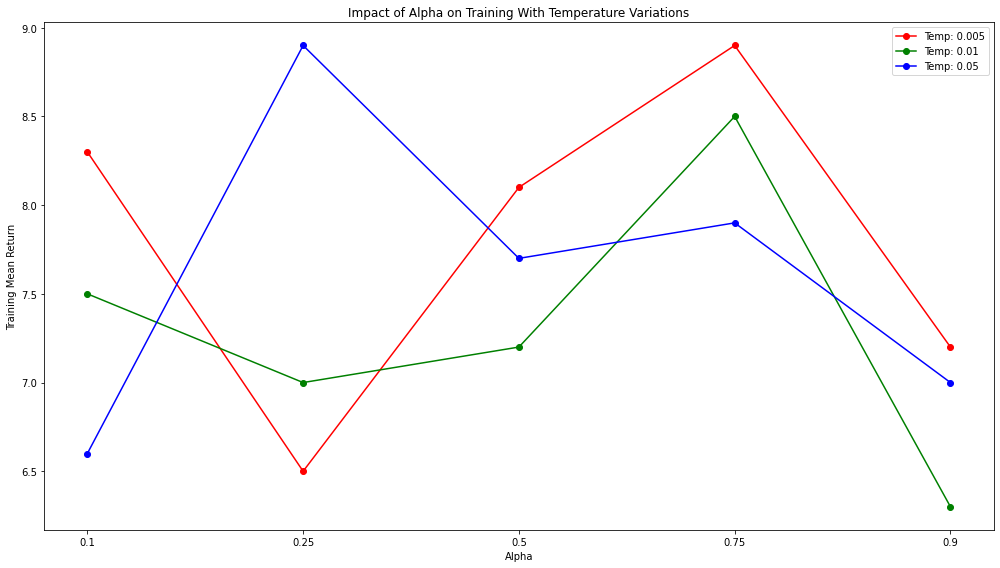

In [65]:
# Adjusting the plotting sequence to have alpha on the X-axis and different lines for each temperature
plt.figure(figsize=(14, 8))

# Updated colormap and line styles for new graph
colors = ['r','g','b']


# Plotting for each temperature
for i,y_means in enumerate(train_y_vals):
    x_indices = range(len(alphas))  # Alphas for X-axis
    plt.plot(x_indices, y_means, marker='o', color=colors[i], label=f"Temp: {temps[i]}")

    # # Shading for visualization of uncertainty
    # for j, x in enumerate(x_indices):
    #     plt.fill_between([x], y_mins[j], y_maxs[j], color=colors[i], alpha=0.1)  # Light shade for range

plt.xticks(x_indices, alphas)  # Alphas on X-axis
plt.xlabel("Alpha")
plt.ylabel("Training Mean Return")
plt.title("Impact of Alpha on Training With Temperature Variations")
plt.legend()
plt.tight_layout()

plt.show()  # Command to visualize the adjusted graph. 


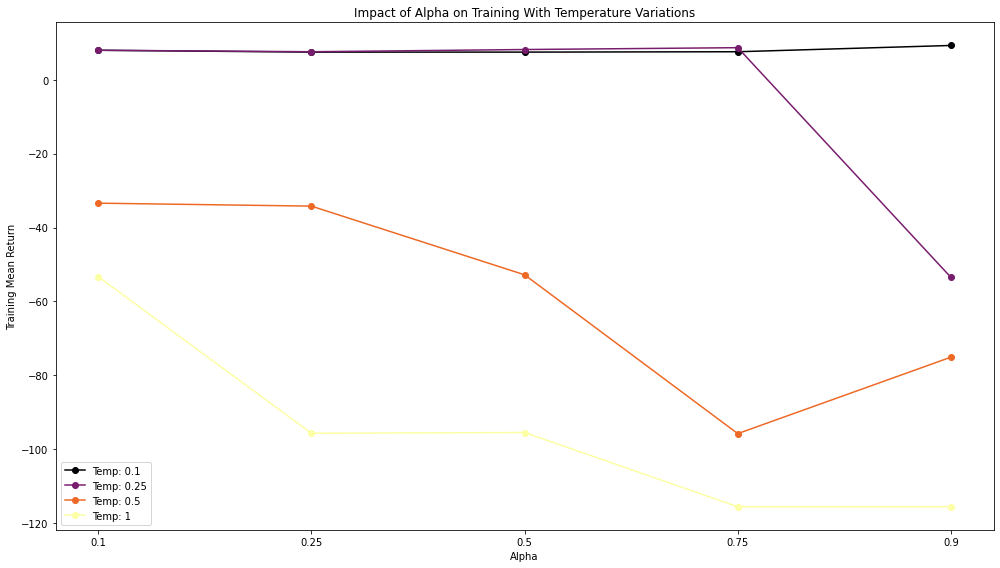

In [54]:
# Adjusting the plotting sequence to have alpha on the X-axis and different lines for each temperature
plt.figure(figsize=(14, 8))

# Updated colormap and line styles for new graph
colors = plt.cm.inferno(np.linspace(0, 1, len(temps)))  # New colormap for temperatures

# Plotting for each temperature
for i,y_means in enumerate(test_y_vals):
    x_indices = range(len(alphas))  # Alphas for X-axis
    plt.plot(x_indices, y_means, marker='o', color=colors[i], label=f"Temp: {temps[i]}")

    # # Shading for visualization of uncertainty
    # for j, x in enumerate(x_indices):
    #     plt.fill_between([x], y_mins[j], y_maxs[j], color=colors[i], alpha=0.1)  # Light shade for range

plt.xticks(x_indices, alphas)  # Alphas on X-axis
plt.xlabel("Alpha")
plt.ylabel("Training Mean Return")
plt.title("Impact of Alpha on Training With Temperature Variations")
plt.legend()
plt.tight_layout()

plt.show()  # Command to visualize the adjusted graph. 
